In [1]:
import os
import ee
import fiona

import numpy as np
import pandas as pd
import geopandas as gp
import rasterio as rio
import matplotlib.pyplot as plt

from shapely.geometry import Polygon, LineString, shape, mapping

from tqdm import tqdm

ee.Initialize()

gp.io.file.fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'
fiona.supported_drivers['KML'] = 'rw'

In [2]:
# Helpers 

def array_from_df(df, variable):    
    '''
    Convets a pandas df with lat, lon, variable to a numpy array 
    Params:
    df - class pd.DataFrame
    variable - str e.g. "B1"
    '''
    # get data from df as arrays
    lons = np.array(df.longitude)
    lats = np.array(df.latitude)
    data = np.array(df[variable]).astype(float) # Set var here 

    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)

    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)    
    nrows = len(uniqueLats)

    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0] 
    xs = uniqueLons[1] - uniqueLons[0]

    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32)

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # start from lower left corner

    return arr

def get_im(im,area, var_name):
    im = ee.ImageCollection(im.clip(area).select(var_name))
    result = im.getRegion(area,30,"epsg:4326").getInfo()
    header, data = result[0], result[1:]

    df = pd.DataFrame(np.column_stack(data).T, columns = header)
    df.latitude = pd.to_numeric(df.latitude)
    df.longitude = pd.to_numeric(df.longitude)
    df[var_name] = pd.to_numeric(df[var_name])

    results = []
    images = []
    for idx,i in enumerate(df.id.unique()):

        t1 = df[df.id==i]
        arr = array_from_df(t1,var_name)
#         arr[arr == 0] = np.nan
        images.append(arr)
    results.append(images) 
    results_out = [item for sublist in results for item in sublist]
    
    return results_out[0]

def apply_mask(im, mask_im):
    return np.where(mask_im !=0, im, np.nan)

def gdf_to_ee_poly(gdf, simplify = False):

    if simplify:
        gdf = gdf.geometry.simplify(0.01)

    lls = gdf.geometry.iloc[0]
    x,y = lls.exterior.coords.xy
    coords = [list(zip(x,y))]
    area = ee.Geometry.Polygon(coords)

    return area



def LineString_to_Poly(file):
    '''
    convert a shpfile of linestring geom type to polygon geom type 
    '''
    
    output = os.path.join(os.path.split(file)[0],os.path.split(file)[1].split(".")[0] + "_poly.shp")
    
    with fiona.open(file) as in_file, fiona.open(output, 'w', 'ESRI Shapefile', {'geometry': 'Polygon',
        'properties' : {'id':'int'}}) as out_file:
        for index_line, row in enumerate(in_file):
            line = shape(row['geometry'])
            coordinates = []

            if isinstance(line, LineString):
                for index, point in enumerate(line.coords):
                    if index == 0:
                        first_pt = point
                    coordinates.append(point)

                coordinates.append(first_pt)
                if len(coordinates) >= 3:
                    polygon = Polygon(coordinates)
                    out_file.write({
                        'geometry': mapping(polygon),
                        'properties': {'id': index_line},
                    })
                    
        print("Wrote {}".format(output))
    
    return gp.read_file(output)

# def shp2kml(shpfn, kmlfn):
#     convert_command = '''ogr2ogr -f 'ESRI Shapefile' {} {} -overwrite'''.format(kmlfn, shpfn)
#     print(convert_command)
#     os.system(convert_command)
#     return kmlfn

In [3]:
# Remove any space in kmls 
kmls = [os.path.join("../shape",x) for x in os.listdir("../shape/") if x.endswith("kml")]
kmls_renamed = [os.path.abspath(x.replace(" ", "")) for x in kmls]

for kml_raw, kml_renamed in zip(kmls, kmls_renamed):
    if not os.path.exists(kml_renamed):
        os.rename(kml_raw, kml_renamed)

# # Convert all kmls to shapefiles (if they dont already exist)
# outfns = [os.path.split(x)[1].split(".")[0].split(" ")[0]+".shp" for x in kmls]
# outpaths = [os.path.abspath(os.path.join("../shape",x)) for x in outfns]

# for shp, kml in zip(outpaths, kmls_renamed):
#     if not os.path.exists(shp):
#         os.chdir("../shape")
#         convert_command = '''ogr2ogr -f 'ESRI Shapefile' {} {} '''.format(shp, kml)
#         print(convert_command)
#         os.system(convert_command)  

In [4]:
fn = "../shape/KML_FVR.kml"
gdf = gp.read_file(fn)

if gdf.geometry.geom_type[0] == "LineString":
    gdf = LineString_to_Poly(fn)
    os.remove(os.path.abspath(fn))
    gdf.to_file(fn, driver='KML',  overwrite = True)

/Users/aakashahamed/anaconda3/envs/rsenv/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [5]:
# Read the kml file (make sure to set gp.io.file.fiona.drvsupport.supported_drivers['LIBKML'] = 'rw')

fn = "../shape/KML_FVR.kml"

# extract all layers 
gdf_list = []
for layer in fiona.listlayers(fn):    
    gdf = gp.read_file(fn, driver='LIBKML', layer=layer)
    if gdf.geometry.geom_type[0] == "Polygon":
        gdf_list.append(gdf)

# concat to gdf  
gdf = gp.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))
# convert to ee object
area = gdf_to_ee_poly(gdf)
# Get area of gdf in sq km 
area_sqkm = area.area(1).getInfo() * 1e-6 # Sq m to sq km

In [6]:
# global forest watch data 
gfw = ee.Image('UMD/hansen/global_forest_change_2022_v1_10')

# Nasa tree cover data 
nasa_tc_2000 = ee.ImageCollection('NASA/MEASURES/GFCC/TC/v3').filter(ee.Filter.date('2000-01-01', '2000-12-31')).select('tree_canopy_cover').mean()
nasa_tc_2005 = ee.ImageCollection('NASA/MEASURES/GFCC/TC/v3').filter(ee.Filter.date('2005-01-01', '2005-12-31')).select('tree_canopy_cover').mean()
nasa_tc_2010 = ee.ImageCollection('NASA/MEASURES/GFCC/TC/v3').filter(ee.Filter.date('2010-01-01', '2010-12-31')).select('tree_canopy_cover').mean()
nasa_tc_2015 = ee.ImageCollection('NASA/MEASURES/GFCC/TC/v3').filter(ee.Filter.date('2015-01-01', '2015-12-31')).select('tree_canopy_cover').mean()

nasa_uc_2000 = ee.ImageCollection('NASA/MEASURES/GFCC/TC/v3').filter(ee.Filter.date('2000-01-01', '2000-12-31')).select('uncertainty').mean()
nasa_uc_2005 = ee.ImageCollection('NASA/MEASURES/GFCC/TC/v3').filter(ee.Filter.date('2005-01-01', '2005-12-31')).select('uncertainty').mean()
nasa_uc_2010 = ee.ImageCollection('NASA/MEASURES/GFCC/TC/v3').filter(ee.Filter.date('2010-01-01', '2010-12-31')).select('uncertainty').mean()
nasa_uc_2015 = ee.ImageCollection('NASA/MEASURES/GFCC/TC/v3').filter(ee.Filter.date('2015-01-01', '2015-12-31')).select('uncertainty').mean()


# Info about NASA tree cover product

The Landsat Vegetation Continuous Fields (VCF) tree cover layers contain estimates of the percentage of horizontal ground in each 30-m pixel covered by woody vegetation greater than 5 meters in height. The dataset is available for four epochs centered on the years 2000, 2005, 2010 and 2015. The dataset is derived from the GFCC Surface Reflectance product (GFCC30SR), which is based on enhanced Global Land Survey (GLS) datasets. The GLS datasets are composed of high-resolution Landsat 5 Thematic Mapper (TM) and Landsat 7 Enhanced Thematic Mapper Plus (ETM+) images at 30 meter resolution.

Tree cover, the proportional, vertically projected area of vegetation (including leaves, stems, branches, etc.) of woody plants above a given height, affects terrestrial energy and water exchanges, photosynthesis and transpiration, net primary production, and carbon and nutrient fluxes. Tree cover also affects habitat quality and movements of wildlife, residential property value for humans, and other ecosystem services. The continuous classification scheme of the VCF product enables better depiction of land cover gradients than traditional discrete classification schemes. Importantly for detection and monitoring of forest changes (e.g., deforestation and degradation), tree cover provides a measurable attribute upon which to define forest cover and its changes. Changes in tree cover over time can be used to monitor and retrieve site-specific histories of forest change.

from: https://developers.google.com/earth-engine/datasets/catalog/NASA_MEASURES_GFCC_TC_v3#bands

### Key takeaways
* trusted and vetted data source - NASA + GLCF project (MODIS + Landsat), validated against lidar
* 30m spatial resolution
* 5y temporal cadence
* RMSE included

In [7]:
# Query the nasa data [TODO: Loop x tqdm this]
t_2000 = get_im(nasa_tc_2000, area, 'tree_canopy_cover')
t_2005 = get_im(nasa_tc_2005, area, 'tree_canopy_cover')
t_2010 = get_im(nasa_tc_2010, area, 'tree_canopy_cover')
t_2015 = get_im(nasa_tc_2015, area, 'tree_canopy_cover')

# build a mask from the zeros across all maps
tc_stack = np.dstack([t_2000,t_2005,t_2010,t_2015]).sum(axis=2)
mask = tc_stack!=0

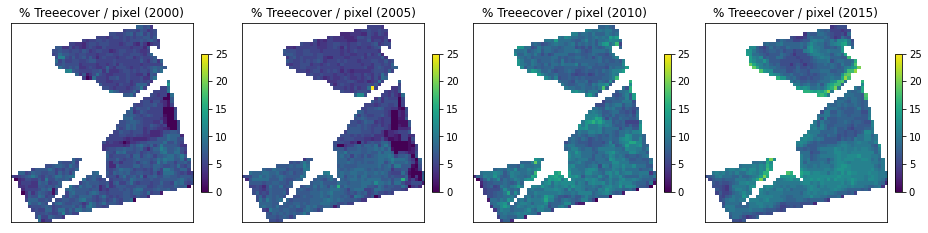

In [8]:
t_2000, t_2005, t_2010, t_2015 = [apply_mask(x, mask) for x in [t_2000, t_2005, t_2010, t_2015]]

# get max val for plotting
maxval = np.nanmax(np.dstack([t_2005,t_2010,t_2015]))

# plot maps 
plt.figure(figsize = (13,6))
plt.subplot(141)
plt.imshow(t_2000, vmin = 0, vmax = maxval); plt.colorbar(fraction=0.035, pad=0.04); plt.title("% Treeecover / pixel (2000)")
plt.xticks([], []); plt.yticks([], [])
plt.subplot(142)
plt.imshow(t_2005, vmin = 0, vmax = maxval); plt.colorbar(fraction=0.035, pad=0.04); plt.title("% Treeecover / pixel (2005)")
plt.xticks([], []); plt.yticks([], [])
plt.subplot(143)
plt.imshow(t_2010, vmin = 0, vmax = maxval); plt.colorbar(fraction=0.035, pad=0.04); plt.title("% Treeecover / pixel (2010)")
plt.xticks([], []); plt.yticks([], [])
plt.subplot(144)
plt.imshow(t_2015, vmin = 0, vmax = maxval); plt.colorbar(fraction=0.035, pad=0.04); plt.title("% Treeecover / pixel (2015)")
plt.xticks([], []); plt.yticks([], [])

plt.tight_layout()
plt.show()

In [9]:

# Get the RMSE from the nasa data [TODO: Loop x tqdm this]
u_2000 = get_im(nasa_uc_2000, area, 'uncertainty')
u_2005 = get_im(nasa_uc_2005, area, 'uncertainty')
u_2010 = get_im(nasa_uc_2010, area, 'uncertainty')
u_2015 = get_im(nasa_uc_2015, area, 'uncertainty')

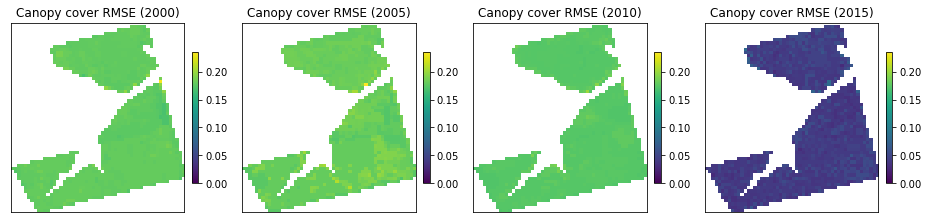

In [10]:
u_2000, u_2005, u_2010, u_2015 = [apply_mask(x, mask) * 0.01 for x in [u_2000, u_2005, u_2010, u_2015]]

# get max val for plotting
maxval = np.nanpercentile(np.dstack([u_2000,u_2005,u_2010,u_2015]), 100)

# plot maps 
plt.figure(figsize = (13,6))
plt.subplot(141)
plt.imshow(u_2000, vmin = 0, vmax = maxval); plt.colorbar(fraction=0.035, pad=0.04); plt.title("Canopy cover RMSE (2000)")
plt.xticks([], []); plt.yticks([], [])
plt.subplot(142)
plt.imshow(u_2005, vmin = 0, vmax = maxval); plt.colorbar(fraction=0.035, pad=0.04); plt.title("Canopy cover RMSE (2005)")
plt.xticks([], []); plt.yticks([], [])
plt.subplot(143)
plt.imshow(u_2010, vmin = 0, vmax = maxval); plt.colorbar(fraction=0.035, pad=0.04); plt.title("Canopy cover RMSE (2010)")
plt.xticks([], []); plt.yticks([], [])
plt.subplot(144)
plt.imshow(u_2015, vmin = 0, vmax = maxval); plt.colorbar(fraction=0.035, pad=0.04); plt.title("Canopy cover RMSE (2015)")
plt.xticks([], []); plt.yticks([], [])

plt.tight_layout()
plt.show()

In [11]:
upper_2000, lower_2000 = t_2000 + (u_2000* t_2000), t_2000 - (u_2000 * t_2000)
upper_2005, lower_2005 = t_2005 + (u_2005* t_2005), t_2005 - (u_2005 * t_2005)
upper_2010, lower_2010 = t_2010 + (u_2010* t_2010), t_2010 - (u_2010 * t_2010)
upper_2015, lower_2015 = t_2015 + (u_2015* t_2015), t_2015 - (u_2015 * t_2015)

In [12]:
low_means = [np.nanmean(x) * 0.01 * area_sqkm for x in [lower_2000, lower_2005, lower_2010, lower_2015]]
up_means = [np.nanmean(x)* 0.01 * area_sqkm for x in [upper_2000, upper_2005, upper_2010, upper_2015]]
means = [np.nanmean(x) * 0.01 * area_sqkm for x in [t_2000, t_2005, t_2010, t_2015]]

Text(0.5, 0, 'year')

<Figure size 576x216 with 0 Axes>

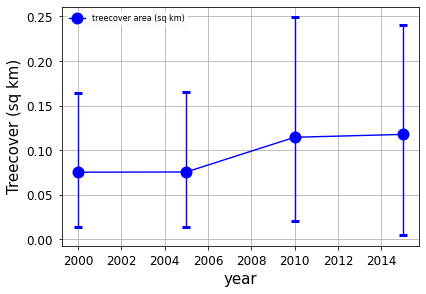

In [13]:
plt.style.use('seaborn-paper')

tcdf = pd.DataFrame([low_means, means, up_means]).T
tcdf.columns = ['lower bound', 'treecover area (sq km)', 'upper bound']
tcdf['date'] = [2000, 2005, 2010, 2015]
tcdf.index = [2000, 2005, 2010, 2015]

plt.figure(figsize = (8,3))
tcdf.plot(y = 'treecover area (sq km)', x = 'date', yerr=[tcdf['lower bound'], tcdf['upper bound']],fontsize = 12, marker = "o", markersize = 12, color = 'blue', capsize=4,capthick=3)
plt.grid()
plt.ylabel("Treecover (sq km)", size = 15)
plt.xlabel("year", size = 15)

In [14]:
treecover_sq_km_2000 = area_sqkm * np.nanmean(t_2000) * 0.01   # Area * mean treecover / px * percent to fraction
treecover_sq_km_2005 = area_sqkm * np.nanmean(t_2005) * 0.01   # Area * mean treecover / px * percent to fraction
treecover_sq_km_2010 = area_sqkm * np.nanmean(t_2010) * 0.01   # Area * mean treecover / px 
treecover_sq_km_2015 = area_sqkm  * np.nanmean(t_2015) * 0.01   # Area * mean treecover / px 

In [15]:
print("2000 treecover area = {} sq km".format(treecover_sq_km_2000))
print("2005 treecover area = {} sq km".format(treecover_sq_km_2005))
print("2010 treecover area = {} sq km".format(treecover_sq_km_2010))
print("2015 treecover area = {} sq km".format(treecover_sq_km_2015))

print("2000 treecover fraction = {} %".format(treecover_sq_km_2000 / area_sqkm* 100))
print("2005 treecover fraction = {} %".format(treecover_sq_km_2005 / area_sqkm* 100))
print("2010 treecover fraction = {} %".format(treecover_sq_km_2010 / area_sqkm* 100))
print("2015 treecover fraction = {} %".format(treecover_sq_km_2015 / area_sqkm* 100))

2000 treecover area = 0.07528207655309392 sq km
2005 treecover area = 0.07551798509443158 sq km
2010 treecover area = 0.11442982409086973 sq km
2015 treecover area = 0.11766135364968781 sq km
2000 treecover fraction = 5.976325035095216 %
2005 treecover fraction = 5.9950528144836435 %
2010 treecover fraction = 9.084098815917969 %
2015 treecover fraction = 9.340636253356934 %


# Global Forest Watch Data 

https://developers.google.com/earth-engine/datasets/catalog/UMD_hansen_global_forest_change_2022_v1_10

Forest loss during the study period, defined as a stand-replacement disturbance (a change from a forest to non-forest state).

Forest gain during the period 2000-2012, defined as the inverse of loss (a non-forest to forest change entirely within the study period). Note that this has not been updated in subsequent versions.


In [16]:
gfw_tc_2000_im = ee.Image('UMD/hansen/global_forest_change_2022_v1_10').select("treecover2000")
gfw_loss_im = ee.Image('UMD/hansen/global_forest_change_2022_v1_10').select("loss")
gfw_gain_im = ee.Image('UMD/hansen/global_forest_change_2022_v1_10').select("gain")

In [17]:
gfw_t_2000 = get_im(gfw_tc_2000_im, area, "treecover2000")
gfw_loss = get_im(gfw_loss_im, area, "loss")
gfw_gain = get_im(gfw_gain_im, area, "gain")

In [18]:
gfw_t_2000, gfw_loss, gfw_gain = [apply_mask(x, mask) for x in [gfw_t_2000, gfw_loss, gfw_gain]]


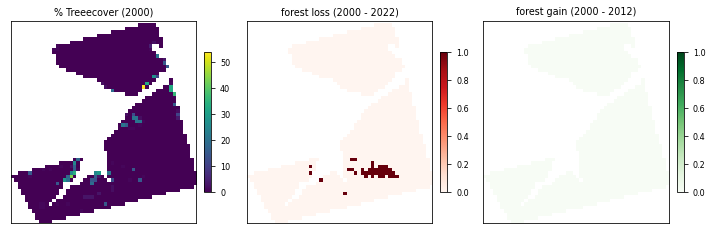

In [19]:
plt.figure(figsize = (10,6))
plt.subplot(131)
plt.imshow(gfw_t_2000); plt.colorbar(fraction=0.035, pad=0.04); plt.title("% Treeecover (2000)")
plt.xticks([], []); plt.yticks([], [])
plt.subplot(132)
plt.imshow(gfw_loss, vmin = 0, vmax = 1, cmap = 'Reds'); plt.colorbar(fraction=0.035, pad=0.04); plt.title("forest loss (2000 - 2022)")
plt.xticks([], []); plt.yticks([], [])
plt.subplot(133)
plt.imshow(gfw_gain, vmin = 0, vmax = 1, cmap = 'Greens'); plt.colorbar(fraction=0.035, pad=0.04); plt.title("forest gain (2000 - 2012)")
plt.xticks([], []); plt.yticks([], [])

plt.tight_layout()
plt.show()

In [20]:
# Loss / Gain statistics

In [21]:
treecover_sq_km_2000 = area_sqkm * np.nanmean(gfw_t_2000) * 0.01   # Area * mean treecover / px 

loss_2000_2020 = np.nansum(gfw_loss) / (gfw_loss.shape[0] * gfw_loss.shape[1]) # fraction of treecover loss
gain_2000_2012 = np.nansum(gfw_gain) / (gfw_gain.shape[0] * gfw_gain.shape[1]) # fraction of treecover gain

loss_sqkm = loss_2000_2020 * area_sqkm
gain_sqkm = gain_2000_2012 * area_sqkm

In [22]:
print("Forest Loss (2000 - 2020) = {} ha ({} sq km)".format(round(loss_sqkm*100,3),round(loss_sqkm,3)))
print("Forest Gain (2000 - 2012) = {} ha ({} sq km)".format(round(gain_sqkm*100,3),round(gain_sqkm,3)))

print("Forest Loss fraction = {} %".format((loss_sqkm/area_sqkm)*100))
print("Forest Gain fraction = {} %".format((gain_sqkm/area_sqkm)*100))

Forest Loss (2000 - 2020) = 1.542 ha (0.015 sq km)
Forest Gain (2000 - 2012) = 0.0 ha (0.0 sq km)
Forest Loss fraction = 1.2241054613935969 %
Forest Gain fraction = 0.0 %


# Globcover Landcover (2009)

https://developers.google.com/earth-engine/datasets/catalog/ESA_GLOBCOVER_L4_200901_200912_V2_3

Not putting much stock into this since it's outdated

In [23]:
lc_ds = ee.Image('ESA/GLOBCOVER_L4_200901_200912_V2_3').select('landcover');

In [24]:
lc_09 = get_im(lc_ds, area, "landcover")

In [25]:
lc_09[lc_09 == 0] = np.nan

In [26]:
def globim2df(cdl_im):
    '''converts numpy array of crop values to pd dataframe with crop categories'''
    # Read cdl lookup table
    df = pd.read_excel("globcover_lookup.xlsx")
    cdl_lookup = dict(zip(df['Value'],df['Category']))
    # Extract the non-nan class values 
    cropvals = [int(x) for x in cdl_im.flatten()[~np.isnan(cdl_im.flatten())]]
    ctypes = []
    for i in cropvals:
        ctypes.append(cdl_lookup[i])
    # count each unique crop type
    values, counts = np.unique(ctypes, return_counts=True)
    # Compile results as dataframe and plot 
    cdf = pd.DataFrame([values, counts]).T
    cdf.columns = ['type', 'npixels']
    cdf['hectares'] = cdf['npixels'] * 900 * 0.0001 # 900 sq m / pixel --> hectares
    return cdf


In [27]:
ctypes = globim2df(lc_09)

<Figure size 460.8x316.8 with 0 Axes>

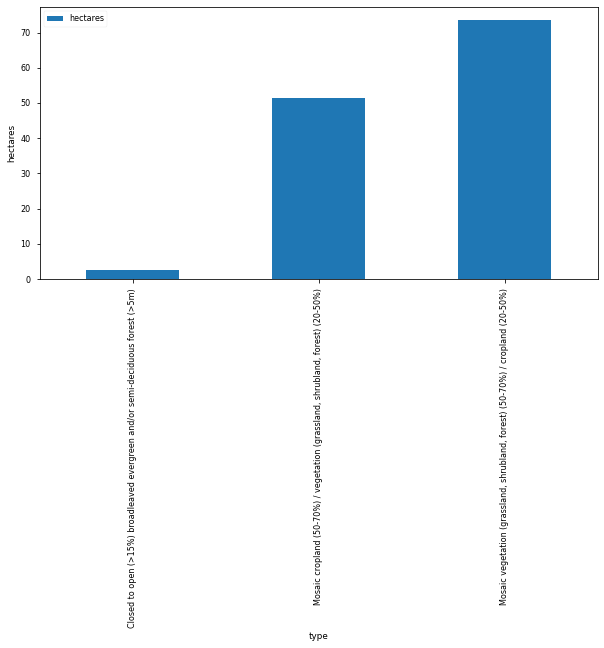

In [28]:
plt.figure()
ctypes.plot(kind = 'bar',x='type', y='hectares',figsize = (10,5))
plt.xticks(rotation=90)
plt.ylabel("hectares")
plt.show()

In [29]:
def dict2arr(data_dict, var_name):
    '''converts ee dictionary output from .getInfo() to a numpy array. Wraps array_from_df'''
    data = data_dict[var_name]
    lats = data_dict['latitude']
    lons = data_dict['longitude']
    df = pd.DataFrame([data,lats,lons]).T
    df.columns = [var_name, "latitude", 'longitude']
    arr = array_from_df(df, var_name)
    return arr


# Forest / Non forest from JAXA + PALSAR

https://developers.google.com/earth-engine/datasets/catalog/JAXA_ALOS_PALSAR_YEARLY_FNF

The global forest/non-forest map (FNF) is generated by classifying the SAR image (backscattering coefficient) in the global 25m resolution PALSAR-2/PALSAR SAR mosaic so that strong and low backscatter pixels are assigned as "forest" and "non-forest", respectively. Here, "forest" is defined as the natural forest with the area larger than 0.5 ha and forest cover over 10%. This definition is the same as the Food and Agriculture Organization (FAO) definition. Since the radar backscatter from the forest depends on the region (climate zone), the classification of Forest/Non-Forest is conducted by using a region-dependent threshold of backscatter. The classification accuracy is checked by using in-situ photos and high-resolution optical satellite images. Detailed information is available in the provider's Dataset Description.

In [30]:

geometry = area
# For some reason, no data from 2011 - 2014
years = list(range(2007, 2010)) + list(range(2015,2018))

lc_ims = {}
for y in tqdm(years):
    print(y)
    year_lc = ee.ImageCollection('JAXA/ALOS/PALSAR/YEARLY/FNF').filterDate('{}-01-01'.format(str(y)), '{}-12-31'.format(str(y)))
    lc = ee.Image(year_lc.first())
    # Compile CDL
    lc_dat = ee.Image.pixelLonLat().addBands(lc).clip(geometry).reduceRegion(reducer=ee.Reducer.toList(),geometry=geometry,scale=30)
    lc_dict = lc_dat.getInfo()
    # Make the ims 
    lc_im = dict2arr(lc_dict, 'fnf')
    lc_ims[y] = lc_im

  0%|          | 0/6 [00:00<?, ?it/s]

2007


 17%|█▋        | 1/6 [00:00<00:01,  3.10it/s]

2008


 33%|███▎      | 2/6 [00:00<00:01,  2.82it/s]

2009


 50%|█████     | 3/6 [00:00<00:00,  3.10it/s]

2015


 67%|██████▋   | 4/6 [00:01<00:00,  3.12it/s]

2016


 83%|████████▎ | 5/6 [00:01<00:00,  3.26it/s]

2017


100%|██████████| 6/6 [00:01<00:00,  3.24it/s]


In [31]:
def get_eligible_pix(im, eligible_list = [2]):
    
    # return 1 for eligible pixels (non forest), 0 otherwise 
    # 

    bin_im = np.zeros_like(im)
    for rowidx in range(0,im.shape[0]):
        for colidx in range(0,im.shape[1]):
            if im[rowidx,colidx] in eligible_list:
                bin_im[rowidx,colidx] = 1
            else:
                bin_im[rowidx,colidx] = 0   
    bin_im = np.where(bin_im==0, np.nan, bin_im)

    return bin_im

el_ims = {}

for year,im in lc_ims.items():
    el = get_eligible_pix(im)
    el_ims[year] = el

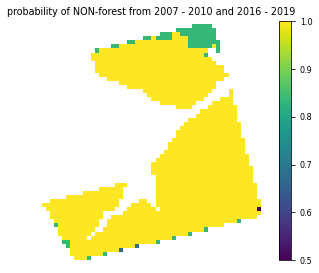

In [32]:
t = np.nansum(np.dstack(list(el_ims.values())[:]), axis = 2)
t2 = apply_mask(t,mask)

plt.imshow(t2/6)
plt.title("probability of NON-forest from 2007 - 2010 and 2016 - 2019")
plt.axis('off')
plt.colorbar()

In [33]:
thresh_im = t2/6
thresh_im[thresh_im < 0.8] = 0
thresh_im[thresh_im >= 0.8] = 1

npix_eligible = np.count_nonzero(~np.isnan(thresh_im))
eligible_area_km2 =  25 * 25 * 1e-6 * npix_eligible

print("Area of >80% forest cover = {}".format(eligible_area_km2)) # sq m to sq km
print("fraction of area that is eligible = {}".format(eligible_area_km2 / area_sqkm))

Area of >80% forest cover = 0.884375
fraction of area that is eligible = 0.7020678353877204


In [34]:
# percent eligible by year 
pixsum = np.nansum(np.dstack(list(el_ims.values())[:]), axis =2)
npix = np.count_nonzero(~np.isnan(pixsum))

{k:np.nansum(v) / npix for k,v in el_ims.items()}

{2007: 0.42059008160703076,
 2008: 0.4438166980539862,
 2009: 0.4438166980539862,
 2015: 0.44413057124921534,
 2016: 0.44318895166352795,
 2017: 0.44413057124921534}

# Wetlands Data from CIFOR 

https://www2.cifor.org/global-wetlands/

The Global Wetlands Map covers the tropics and subtropics regions (40° N to 60° S; 180° E to -180° W), excluding small islands. This mapping is a hydro-geomorphological model based on an Expert System approach to estimate wetland areas, which relies on three biophysical indices related to wetland and peat formation: (1) long-term water supply exceeding atmospheric water demand; (2) annually or seasonally waterlogged soils; and (3) a geomorphological position where water is supplied and retained (Gumbricht et al. 2017).

In [35]:
bbox_geom = gdf.copy()
bbox_geom['geometry'] = bbox_geom.envelope

In [36]:
bbox_geom = gdf.copy()
bbox_geom['geometry'] = bbox_geom['geometry'].envelope
bbox_geom.to_file(fn.replace("kml","shp"))

# Clip raster to shapefile extent
wetlands = os.path.abspath("../data/wetlands/TROP-SUBTROP_WetlandV3b_2016_CIFOR.tif")
shpfns = [os.path.join("../shape",x) for x in os.listdir("../shape/") if x.endswith(".shp")]
clip_dir = os.path.abspath(os.path.join("../data/wetlands/","clipped"))
if not os.path.exists(clip_dir):
    os.mkdir(clip_dir)

out_files = []
for shp in shpfns:
    out_tif = os.path.abspath(shp).replace("shape",'data/wetlands/clipped').split(".")[0]  + ".tif"
    out_files.append(out_tif)
    if not os.path.exists(out_tif):
        clip_cmd = '''gdalwarp -cutline {} -crop_to_cutline {} {}'''.format(os.path.abspath(shp),wetlands,out_tif)
        print(clip_cmd)
        os.system(clip_cmd)

<ipython-input-36-97b4aae79387>:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  bbox_geom.to_file(fn.replace("kml","shp"))


In [37]:
for file in out_files:
    if os.path.exists(file):
        src = rio.open(file)
        arr = src.read(1)
        if np.nansum(arr) == 0:
            print("NO WETLANDS DETECTED IN PROJECT AREA")
        else:
            print("WETLANDS DETECTED, see {} for more information ".format(file))
    else:
        print("NO WETLANDS FILE FOR STUDY AREA")

NO WETLANDS DETECTED IN PROJECT AREA


# SOC Data from FAO

https://www.fao.org/soils-portal/data-hub/soil-maps-and-databases/global-soil-organic-carbon-map-gsocmap/en/

https://www.fao.org/3/I8891EN/i8891en.pdf

Flag areas where SOC >50% (histosol definition, I believe)

* need to convert T / ha --> %s 


In [38]:
# Clip raster to shapefile extent
soc = os.path.abspath("../data/soil_carbon/GSOCmap1.5.0.tif")
shpfns = [os.path.join("../shape",x) for x in os.listdir("../shape/") if x.endswith(".shp")]
clip_dir = os.path.abspath(os.path.join("../data/soil_carbon/","clipped"))
if not os.path.exists(clip_dir):
    os.mkdir(clip_dir)

out_files = []
for shp in shpfns:
    out_tif = os.path.abspath(shp).replace("shape",'data/soil_carbon/clipped').split(".")[0]  + ".tif"
    out_files.append(out_tif)
    if not os.path.exists(out_tif):
        clip_cmd = '''gdalwarp -cutline {} -crop_to_cutline -dstalpha {} {}'''.format(os.path.abspath(shp),soc,out_tif)
        print(clip_cmd)
        os.system(clip_cmd)

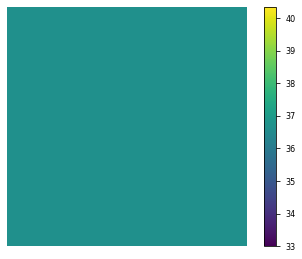

In [39]:
for file in out_files:
    if os.path.exists(file):
        src = rio.open(file)
        arr = src.read(1)
        arr[arr==0] = np.nan
        plt.imshow(arr);plt.colorbar(); plt.axis('off'); plt.show()